In [34]:
import sounddevice as sd
from scipy.io.wavfile import write
from pydub import AudioSegment
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

devices available

In [35]:
# Display available audio devices
print(sd.query_devices())


  0 Sam’s iPhone Microphone, Core Audio (1 in, 0 out)
> 1 MacBook Pro Microphone, Core Audio (1 in, 0 out)
< 2 MacBook Pro Speakers, Core Audio (0 in, 2 out)


recording

In [36]:
# Parameters for recording
SAMPLE_RATE = 44100  # Sample rate
DURATION = 10        # Duration in seconds
CHANNELS = 1         # Number of channels
DEVICE_INDEX = 1     # MacBook Pro Microphone
WAV_FILENAME = "output.wav"
MP3_FILENAME = "output.mp3"

# Record audio
print("Recording...")
audio_data = sd.rec(int(SAMPLE_RATE * DURATION), samplerate=SAMPLE_RATE, channels=CHANNELS, dtype='int16', device=DEVICE_INDEX)
sd.wait()  # Wait until recording is finished
print("Recording finished.")

# Save as WAV file
write(WAV_FILENAME, SAMPLE_RATE, audio_data)

# Convert WAV to MP3

Recording...
Recording finished.


convert to mp3

In [37]:
audio = AudioSegment.from_wav(WAV_FILENAME)
audio.export(MP3_FILENAME, format="mp3")
print(f"Audio recorded and saved as {MP3_FILENAME}")

# Plot the waveform of the recorded audio
audio_data = audio_data.flatten()  # Flatten the array if it's multi-dimensional
time = np.linspace(0., DURATION, audio_data.shape[0])

display(audio_data)

Audio recorded and saved as output.mp3


array([  29,   88,  190, ..., -246, -456, -634], dtype=int16)

plotting

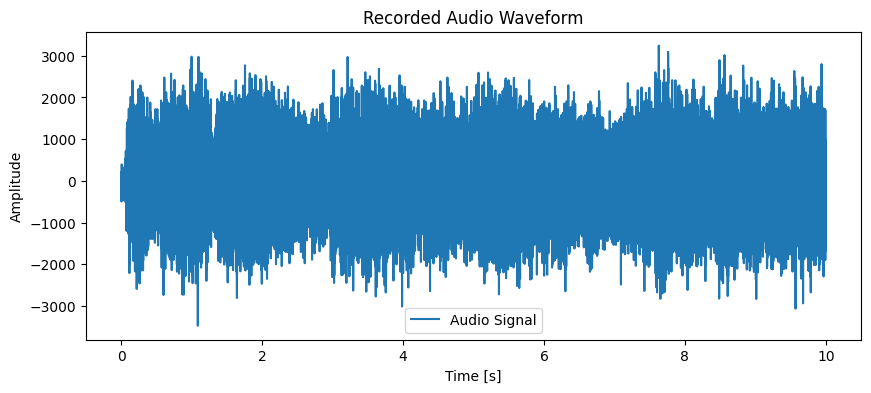

In [38]:

plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, label="Audio Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Recorded Audio Waveform")
plt.legend()
plt.show()


importing dependancies

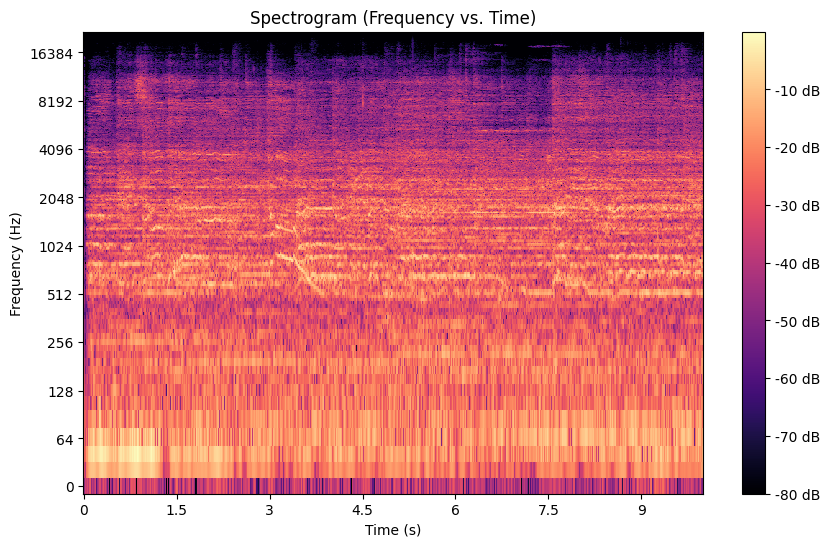

In [39]:
y, sr = librosa.load(WAV_FILENAME, sr=SAMPLE_RATE)

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Convert the complex values to decibels
DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Frequency vs. Time)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [40]:
print(DB)

[[-32.258736 -46.731255 -35.232124 ... -47.88095  -51.199345 -16.177528]
 [-28.790758 -30.614079 -38.730064 ... -16.814322 -15.22094  -13.630699]
 [-25.459688 -24.436054 -25.989388 ... -19.72044  -13.238618 -12.536578]
 ...
 [-80.       -80.       -80.       ... -80.       -77.85778  -65.76915 ]
 [-80.       -80.       -80.       ... -80.       -75.61423  -65.586754]
 [-80.       -80.       -80.       ... -80.       -78.01921  -65.59697 ]]


window slicing

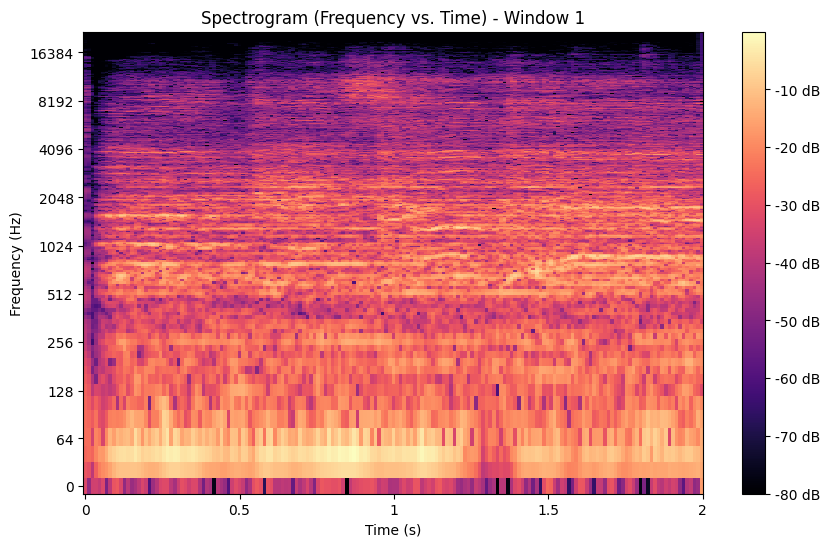

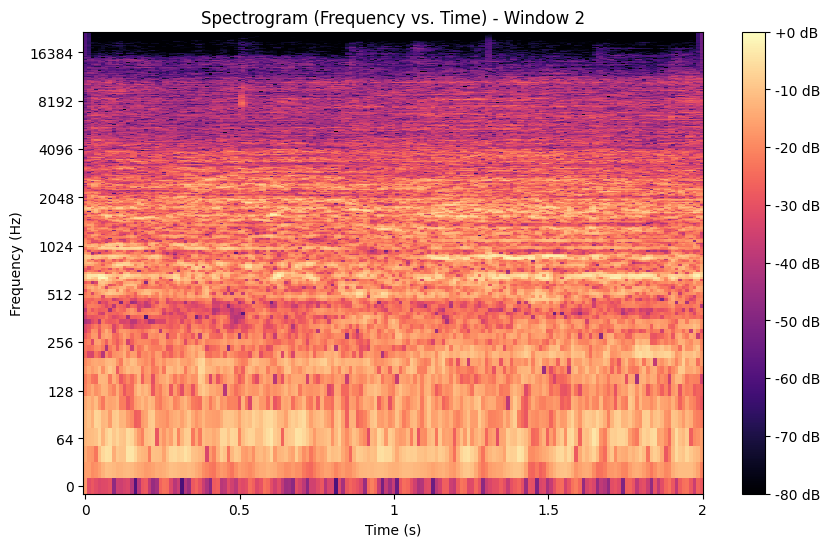

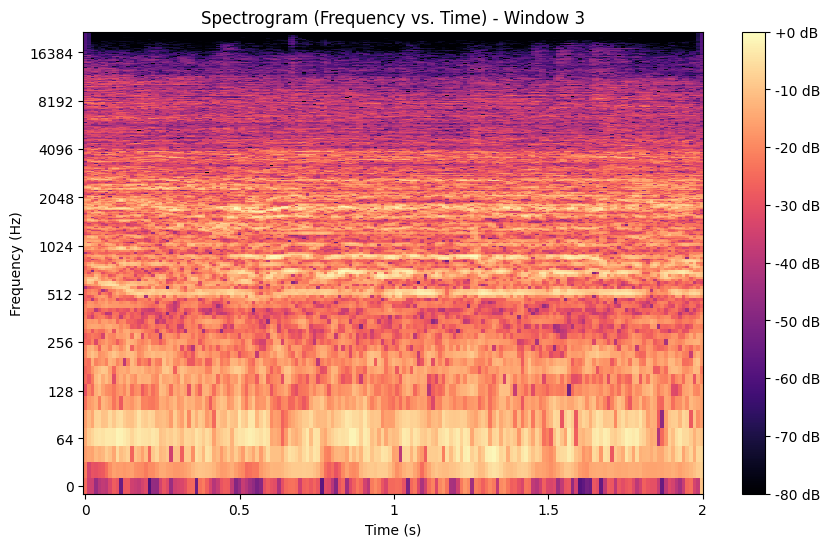

In [41]:
y, sr = librosa.load(WAV_FILENAME, sr=SAMPLE_RATE)

# Define window parameters
WINDOW_SIZE = 2 * sr  # 2 seconds
HOP_LENGTH = 4 * sr   # 4 seconds

# Perform STFT on each window
stft_results = []

# Loop through the audio in steps of HOP_LENGTH
for start in range(0, len(y), HOP_LENGTH):
    end = start + WINDOW_SIZE
    if end > len(y):
        break
    window = y[start:end]
    stft_result = librosa.stft(window)
    stft_results.append(stft_result)

# Display spectrogram for each window
for i, stft_result in enumerate(stft_results):
    plt.figure(figsize=(10, 6))
    DB = librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)
    librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (Frequency vs. Time) - Window {i + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

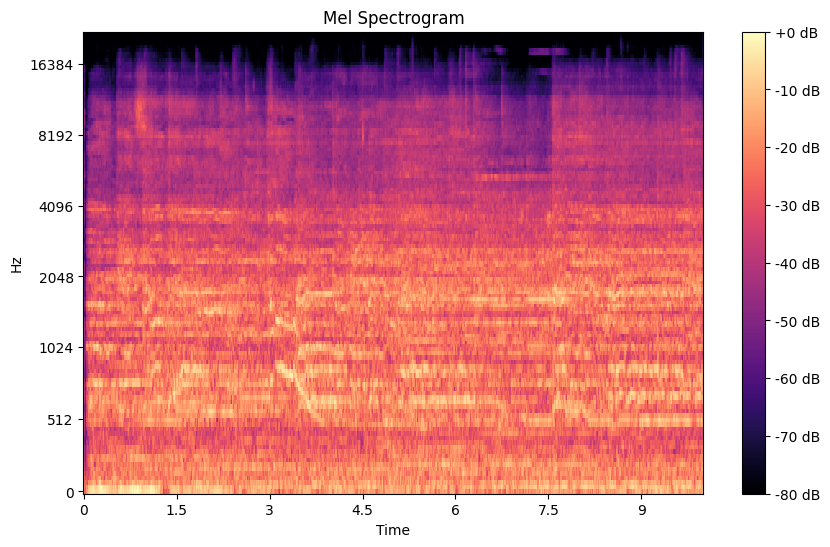

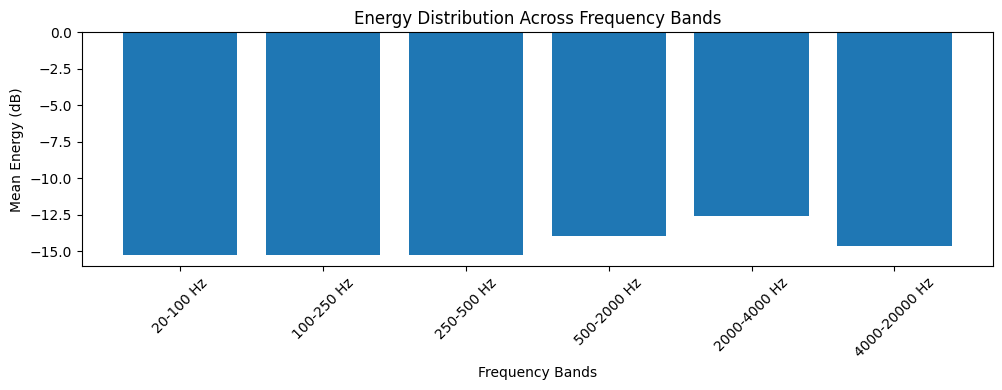

In [42]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Assuming you've already loaded your audio file
y, sr = librosa.load(WAV_FILENAME, sr=SAMPLE_RATE)

# Compute the mel spectrogram
n_mels = 128  # Number of mel bands
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)

# Convert to dB scale
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

# Define frequency bands (in Hz)
bands = [
    (20, 100),    # Sub-bass
    (100, 250),   # Bass
    (250, 500),   # Low midrange
    (500, 2000),  # Midrange
    (2000, 4000), # Upper midrange
    (4000, 20000) # High frequency
]

# Convert frequency bands to mel scale
mel_bands = [librosa.hz_to_mel(band) for band in bands]

# Analyze energy in each band
band_energies = []
for start_mel, end_mel in mel_bands:
    # Find the corresponding indices in the mel spectrogram
    start_idx = np.argmin(np.abs(librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2) - start_mel))
    end_idx = np.argmin(np.abs(librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2) - end_mel))
    
    # Calculate the mean energy in the band
    band_energy = np.mean(S_dB[start_idx:end_idx+1, :])
    band_energies.append(band_energy)

# Plot the band energies
plt.figure(figsize=(10, 4))
plt.bar(range(len(bands)), band_energies)
plt.xlabel('Frequency Bands')
plt.ylabel('Mean Energy (dB)')
plt.title('Energy Distribution Across Frequency Bands')
plt.xticks(range(len(bands)), [f'{b[0]}-{b[1]} Hz' for b in bands], rotation=45)
plt.tight_layout()
plt.show()